In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
import scipy.io as sio
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

In [10]:
def build_batchnorm_cnn_no_do(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv1D(kernel_size=25, filters=8, strides=1, padding='valid', 
                  activation='relu', input_shape=input_shape))  
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid', 
                          activation='relu'))  
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
#         model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [11]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.0500 - acc: 0.4181
Epoch 00001: val_loss improved from inf to 1.41715, saving model to model/checkpoint/1D_BN_CNN_NO_DO_1_conv_1_fcn_checkpoint/01-1.4171.hdf5
36805/36805 [==============================] - 30s 810us/step - loss: 2.0500 - acc: 0.4181 - val_loss: 1.4171 - val_acc: 0.5691
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6964 - acc: 0.7872
Epoch 00002: val_loss improved from 1.41715 to 1.15374, saving model to model/checkpoint/1D_BN_CNN_NO_DO_1_conv_1_fcn_checkpoint/02-1.1537.hdf5
36805/36805 [==============================] - 28s 770us/step - loss: 0.6964 - acc: 0.7873 - val_loss: 1.1537 - val_acc: 0.6629
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2731 - acc: 0.9265
Epoch 00003: val_loss improved from 1.15374 to 1.13011, saving model to model/checkpoint/1D_BN_CNN_NO_DO_1_conv_1_fcn_check

Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9923
Epoch 00030: val_loss did not improve from 1.13011
36805/36805 [==============================] - 28s 765us/step - loss: 0.0329 - acc: 0.9923 - val_loss: 2.0879 - val_acc: 0.7105
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9908
Epoch 00031: val_loss did not improve from 1.13011
36805/36805 [==============================] - 28s 765us/step - loss: 0.0420 - acc: 0.9908 - val_loss: 2.0032 - val_acc: 0.7195
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9957
Epoch 00032: val_loss did not improve from 1.13011
36805/36805 [==============================] - 28s 765us/step - loss: 0.0284 - acc: 0.9957 - val_loss: 2.0647 - val_acc: 0.7098
Epoch 33/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9963
Epoch 00033: val_loss did not improve from 1.13011
36805/36805 [===========

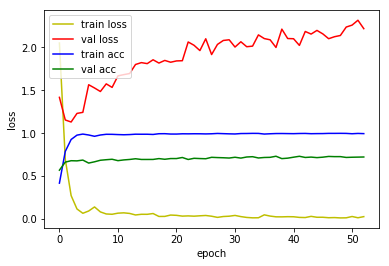

4815/4815 [==============================] - 1s 196us/step
Loss: 1.4688219421749173 Accuracy: 0.6026998962321137

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.8706 - acc: 0.4186
Epoch 00001: val_loss improved from inf to 1.35549, saving model to model/checkpoint/1D_BN_CNN_NO_DO_1_conv_2_fcn_checkpoint/01-1.3555.hdf5
36805/36805 [==============================] - 30s 803us/step - loss: 1.8704 - acc: 0.4187 - val_loss: 1.3555 - val_acc: 0.5742
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7722 - acc: 0.7553
Epoch 00002: val_loss improved from 1.35549 to 1.11782, saving model to model/checkpoint/1D_BN_CNN_NO_DO_1_conv_2_fcn_checkpoint/02-1.1178.hdf5
36805/36805 [==============================] - 29s 779us/step - loss: 0.7722 - acc: 0.7553 - val_loss: 1.1178 - val_acc: 0.6417
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3142 - acc: 0.9082
Epoch 000

Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9937
Epoch 00030: val_loss did not improve from 1.11782
36805/36805 [==============================] - 28s 773us/step - loss: 0.0257 - acc: 0.9937 - val_loss: 1.9228 - val_acc: 0.7135
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9910
Epoch 00031: val_loss did not improve from 1.11782
36805/36805 [==============================] - 28s 774us/step - loss: 0.0423 - acc: 0.9910 - val_loss: 1.9461 - val_acc: 0.7000
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9934
Epoch 00032: val_loss did not improve from 1.11782
36805/36805 [==============================] - 28s 773us/step - loss: 0.0274 - acc: 0.9934 - val_loss: 1.9496 - val_acc: 0.7098
Epoch 33/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9954
Epoch 00033: val_loss did not improve from 1.11782
36805/36805 [===========

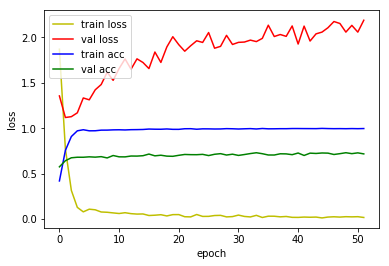

4815/4815 [==============================] - 1s 204us/step
Loss: 1.2755809808198288 Accuracy: 0.641744548360878

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6525 - acc: 0.5119
Epoch 00001: val_loss improved from inf to 2.56027, saving model to model/checkpoint/1D_BN_CNN_NO_DO_2_conv_1_fcn_checkpoint/01-2.5603.hdf5
36805/36805 [==============================] - 27s 738us/step - loss: 1.6524 - acc: 0.5119 - val_loss: 2.5603 - val_acc: 0.3813
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5134 - acc: 0.8398
Epoch 00002: val_loss improved from 2.56027 to 0.87183, saving model to model/checkpoint/1D_BN_CNN_NO_DO_2_conv_1_fcn_checkpoint/02-0.8718.hdf5
36805/36805 [==============================] - 26s 702us/step - loss: 0.5134 - acc: 0.8398 - val_loss: 0.8718 - val_acc: 0.7230
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1570 - acc: 0.9608
Epoch 0000

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9963
Epoch 00029: val_loss did not improve from 0.76928
36805/36805 [==============================] - 26s 699us/step - loss: 0.0147 - acc: 0.9963 - val_loss: 1.4917 - val_acc: 0.7652
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9977
Epoch 00030: val_loss did not improve from 0.76928
36805/36805 [==============================] - 26s 698us/step - loss: 0.0108 - acc: 0.9977 - val_loss: 1.5791 - val_acc: 0.7741
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9962
Epoch 00031: val_loss did not improve from 0.76928
36805/36805 [==============================] - 26s 699us/step - loss: 0.0148 - acc: 0.9962 - val_loss: 1.3670 - val_acc: 0.7771
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9964
Epoch 00032: val_loss did not improve from 0.76928
36805/36805 [===========

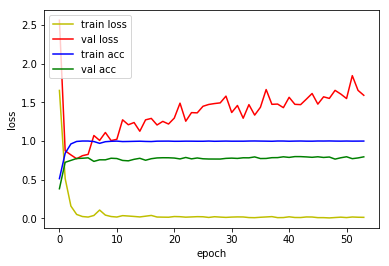

4815/4815 [==============================] - 1s 276us/step
Loss: 0.8787733819502042 Accuracy: 0.7557632399496631

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4737 - acc: 0.5393
Epoch 00001: val_loss improved from inf to 1.85543, saving model to model/checkpoint/1D_BN_CNN_NO_DO_2_conv_2_fcn_checkpoint/01-1.8554.hdf5
36805/36805 [==============================] - 28s 760us/step - loss: 1.4739 - acc: 0.5393 - val_loss: 1.8554 - val_acc: 0.4645
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4957 - acc: 0.8455
Epoch 00002: val_loss improved from 1.85543 to 0.73992, saving model to model/checkpoint/1D_BN_CNN_NO_DO_2_conv_2_fcn_checkpoint/02-0.7399.hdf5
36805/36805 [==============================] - 26s 710us/step - loss: 0.4959 - acc: 0.8454 - val_loss: 0.7399 - val_acc: 0.7596
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9585
Epoch 000

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9966
Epoch 00029: val_loss did not improve from 0.69580
36805/36805 [==============================] - 26s 706us/step - loss: 0.0127 - acc: 0.9966 - val_loss: 1.3158 - val_acc: 0.8020
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9964
Epoch 00030: val_loss did not improve from 0.69580
36805/36805 [==============================] - 26s 706us/step - loss: 0.0120 - acc: 0.9964 - val_loss: 1.2635 - val_acc: 0.7980
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9970
Epoch 00031: val_loss did not improve from 0.69580
36805/36805 [==============================] - 26s 706us/step - loss: 0.0120 - acc: 0.9970 - val_loss: 1.6292 - val_acc: 0.7666
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9944
Epoch 00032: val_loss did not improve from 0.69580
36805/36805 [===========

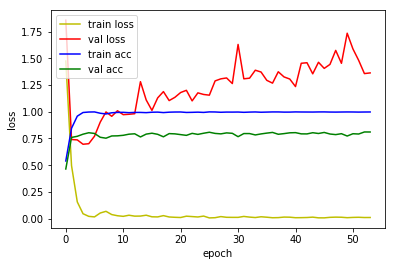

4815/4815 [==============================] - 1s 310us/step
Loss: 0.8699938876359015 Accuracy: 0.7603322949860079

Train on 36805 samples, validate on 4293 samples
Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[64,1,969,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_8/Adam/gradients/max_pooling1d_8/MaxPool_grad/MaxPoolGrad-0-0-TransposeNCHWToNHWC-LayoutOptimizer}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_8/Adam/gradients/max_pooling1d_8/MaxPool_grad/MaxPoolGrad, PermConstNCHWToNHWC-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [12]:
for i in range(1, 6):
    for j in range(1, 3):
        model = build_batchnorm_cnn_no_do(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/1D_BN_CNN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])
        print()
        print('{} Conv {} FCN Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()

        png_path = 'visualization/learning_curve/'
        filename = '1D_BN_CNN_NO_DO_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)

        del(model)
        
        model_path = 'model/checkpoint/1D_BN_CNN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [ ]:
for i in range(1, 6):
    for j in range(1, 3):
        print()
        print('{} Conv {} FCN Model'.format(i, j))
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/1D_BN_CNN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        
        del(model)